In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scipy

π = np.pi
µs_to_ns = 1e3
norm_fact = 1/(np.sqrt(2))

## Capacitively Coupled Qutrits

In [2]:
#states
num_qubit_states = 3

g_state = qt.basis(num_qubit_states, 0)
e_state = qt.basis(num_qubit_states, 1)
f_state = qt.basis(num_qubit_states, 2)

#operators
b1 = qt.tensor(qt.destroy(num_qubit_states), qt.qeye(num_qubit_states))
b1dag = b1.dag() 
b2 = qt.tensor(qt.qeye(num_qubit_states), qt.destroy(num_qubit_states))
b2dag = b2.dag() 

gg_proj = qt.tensor(g_state, g_state).proj()
ge_proj = qt.tensor(g_state, e_state).proj()
gf_proj = qt.tensor(g_state, f_state).proj()

eg_proj = qt.tensor(e_state, g_state).proj()
ee_proj = qt.tensor(e_state, e_state).proj()
ef_proj = qt.tensor(e_state, f_state).proj()

fg_proj = qt.tensor(f_state, g_state).proj()
fe_proj = qt.tensor(f_state, e_state).proj()
ff_proj = qt.tensor(f_state, f_state).proj()

In [ ]:
0, 0
1, 0, 0, 0, 0, 0, 0, 0, 0


1, 0
0, 1, 0, 0, 0 

0, 1


## Hamiltonian
$H/\hbar = \sum_{i=1}^2{\left(\omega_i b_i^\dagger b_i + \frac{\alpha_i}{2} b_i^\dagger b_i^\dagger b_i b_i\right)} + J(b_1^\dagger b_2+b_2^\dagger b_1+b_1^\dagger b_2^\dagger+b_1 b_2)$

In [3]:
#hamiltonian in harmonic oscillator basis, eigenvectors belong to this basis (harmonic oscillator)
#calculate eigenvectors of this hamiltonian for the eigenvectors
#set of eigenvectors (hermitian operator, set of eigenvectors form a complete basis), can make a transformation matrix
#can use this transformation matrix to transform propogator into the eigenbasis of the hamiltonian (computational basis)
#now in the computational basis- you can truncate the transformed propogator by ignoring anything beyond 4x4 (process)

In [4]:
def hamiltonian(omega_1, omega_2, alpha_1, alpha_2, J_coupling):
    t1 = (omega_1 * b1dag * b1) + (omega_2 * b2dag * b2)
    t2 = (alpha_1 / 2 * b1dag * b1dag * b1 * b1) + (alpha_2 / 2 * b2dag * b2dag * b2 * b2)
    t4 = J_coupling * (b1dag * b2 + b2dag * b1)
    #t5 = J_coupling * (b1dag * b2dag + b1 * b2)
    return t1 + t2 + t4# + t5

def nocounter(omega_1, omega_2, alpha_1, alpha_2, J_coupling):
    t1 = (omega_1 * b1dag * b1) + (omega_2 * b2dag * b2)
    t2 = (alpha_1 / 2 * b1dag * b1dag * b1 * b1) + (alpha_2 / 2 * b2dag * b2dag * b2 * b2)
    t4 = J_coupling * (b1dag * b2 + b2dag * b1)
    return t1 + t2 + t4

### side pursuit (gate times w/, w/o, c.r. terms, and analytical)

0.7853981633974483 0.7853981633974483 0.7853981633974483
0.4999921468755914 0.4999921468755914 0.5


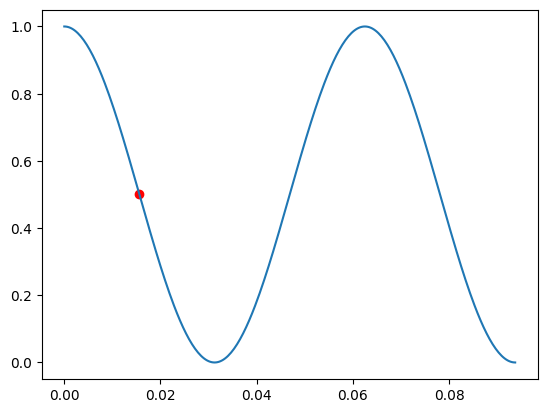

In [5]:
def calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, plotbool):
    h = hamiltonian(omega_1=omega1, omega_2=omega2, alpha_1=alpha, alpha_2=alpha, J_coupling=J_coupling)
    psi0 = qt.tensor(e_state, g_state) #start in eg state
    te = qt.mesolve(h, psi0, t_vec, [], []) #time evolve with t_vec
    eg_pops = qt.expect(eg_proj, te.states)
    argmin = np.argmin(np.abs(eg_pops-0.5)[1:]) + 1 #argument of value closest to 0.5
    if plotbool == True:
        fig = plt.figure()
        plt.plot(t_vec, eg_pops) #blue line
        plt.scatter(t_vec[argmin], eg_pops[argmin], c='r') #red dot 
    return eg_pops[argmin], t_vec[argmin], argmin

J_coupling = 2*π * 8
t_start = 0
t_end = 6 * π/(4*J_coupling) #π/4J ~ reach maximally entangled state (Jt = π/4)
t_vec = np.linspace(t_start, t_end, 301)
omega1 = 2*π * 6000
omega2 = 2*π * 6000
alpha = 2*π * -300

pop, gatetime, arg = calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, True)
pop_no, gatetime_no, arg_no = calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, nocounter, False)

#note in 2010 Nature Paper Bialczak SQiSW: g/2 = J, gt = π/2, Jt = π/4
print(J_coupling * gatetime, J_coupling * gatetime_no, π/4)
print(pop, pop_no, 0.5)

#### Takeaways: 
- population number for w/, w/o c.r. terms are different (good)
- lower number of points in t_vec leads to different gatetimes from analytical (w/, w/o always identical)

## Sanity Check
1. Start: 4 initial wave functions <br>
2. Evolve until full population is recovered using: i: mesolve, ii: propogator, iii: unitary <br>
3. Check fidelities of final states (should all be 1)

In [6]:
_, gatetime, _ = calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, False)
h = hamiltonian(omega_1=omega1, omega_2=omega2, alpha_1=alpha, alpha_2=alpha, J_coupling=J_coupling)
sanity_t_vec = np.linspace(t_start, 4*gatetime, 601) #time vector to recover all of initial population (4*SQiSW time)

psi0 = qt.Qobj(np.array(qt.tensor(g_state, g_state)))
psi1 = qt.Qobj(np.array(qt.tensor(g_state, e_state)))
psi2 = qt.Qobj(np.array(qt.tensor(e_state, g_state)))
psi3 = qt.Qobj(np.array(qt.tensor(e_state, e_state)))

def compute_propogator(h, t_vec): #output propogator matrix
    propogator = qt.propagator(h, t_vec)
    prop = qt.Qobj(np.array(propogator[-1]))
    return prop

def compute_unitary(phi_1, phi_2, phi_3): #output theoretical unitary evolution matrix
    return qt.Qobj(np.array(
        qt.tensor(g_state, g_state).proj() * 1
        + qt.tensor(e_state, g_state).proj() * np.exp(1j*phi_1)
        + qt.tensor(g_state, e_state).proj() * np.exp(1j*phi_2)
        + qt.tensor(f_state, g_state).proj() * 1
        + qt.tensor(e_state, e_state).proj() * np.exp(1j*phi_3)
        + qt.tensor(g_state, f_state).proj() * 1
        + qt.tensor(f_state, e_state).proj() * 1
        + qt.tensor(e_state, f_state).proj() * 1
        + qt.tensor(f_state, f_state).proj() * 1
    ))

def sesolve_evolution(psi0, psi1, psi2, psi3, h): #output final states
    te0 = qt.mesolve(h, psi0, sanity_t_vec, [], [])
    te1 = qt.mesolve(h, psi1, sanity_t_vec, [], [])
    te2 = qt.mesolve(h, psi2, sanity_t_vec, [], [])
    te3 = qt.mesolve(h, psi3, sanity_t_vec, [], [])
    return te0.states[-1], te1.states[-1], te2.states[-1], te3.states[-1]  

sanityprop = compute_propogator(h, sanity_t_vec)
sanitytunit = compute_unitary(π/4, π/4, π)
s0, s1, s2, s3 = sesolve_evolution(psi0, psi1, psi2, psi3, h)

print(qt.fidelity(s0, sanityprop * psi0))
print(qt.fidelity(s1, sanityprop * psi1))
print(qt.fidelity(s2, sanityprop * psi2))
print(qt.fidelity(s3, sanityprop * psi3))
print(qt.fidelity(s0, sanitytunit * psi0))
print(qt.fidelity(s1, sanitytunit * psi1))
print(qt.fidelity(s2, sanitytunit * psi2))
print(qt.fidelity(s3, sanitytunit * psi3))

1.0
0.999999999203102
0.9999999992031019
0.999999997249214
1.0
0.999999999202444
0.9999999992024438
0.9989328192244116


##### ____ _______End of Sanity Check_______ ____

## SQiSW Simulation
### Propogator

In [9]:
_, gatetime, _ = calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, False)
h = hamiltonian(omega_1=omega1, omega_2=omega2, alpha_1=alpha, alpha_2=alpha, J_coupling=J_coupling)
newt_vec = np.linspace(t_start, gatetime, 601)
psi0 = qt.Qobj(np.array(qt.tensor(e_state, g_state)))
te0 = qt.mesolve(h, psi0, newt_vec, [], [])
te0.states[-1]

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.00000000e+00+0.00000000e+00j]
 [7.07107940e-01-7.01520900e-05j]
 [0.00000000e+00+0.00000000e+00j]
 [7.19897514e-05+7.07105616e-01j]
 [0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j]]

In [10]:
_, gatetime, _ = calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, False)
h = hamiltonian(omega_1=omega1, omega_2=omega2, alpha_1=alpha, alpha_2=alpha, J_coupling=J_coupling)
newt_vec = np.linspace(t_start, gatetime, 601)
propogator = compute_propogator(h, newt_vec)
propogator

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  9.36085617e-07+7.07106771e-01j
   0.00000000e+00+0.00000000e+00j  7.07106791e-01-1.09415497e-06j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   3.41802782e-01+9.36948560e-01j  0.00000000e+00+0.00000000e+00j
  -4.87856365e-02-3.25875822e-02j  0.00000000e+00+0.00000000e+00j
  -4.10441432e-02+1.31367520e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.0000000

In [21]:
qt.Qobj(propogator[0:4,0:4])

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 9.36085617e-07+7.07106771e-01j
  0.00000000e+00+0.00000000e+00j 7.07106791e-01-1.09415497e-06j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  3.41802782e-01+9.36948560e-01j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 7.07106791e-01-1.09415497e-06j
  0.00000000e+00+0.00000000e+00j 9.36085617e-07+7.07106771e-01j]]

In [12]:
(propogator * psi0) - te0.states[-1]

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j]
 [-1.14877138e-06+6.90579350e-05j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-7.10536657e-05+1.15591632e-06j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]]

### Generate Transformation Matrix 
(change propogator from harmonic oscillator to hamiltonian eigenbasis in order to compare to theoretical SQiSW 4x4 operator)

In [13]:
def transformation(matrix, prop):
    eig, eigstates = matrix.eigenstates()
    obj = (
        np.array(eigstates[0]), np.array(eigstates[1]), np.array(eigstates[2]), 
        np.array(eigstates[3]), np.array(eigstates[4]), np.array(eigstates[5]),
        np.array(eigstates[6]), np.array(eigstates[7]), np.array(eigstates[8]),
    )
    U = np.column_stack(obj) #stack the eigenstates of the hamiltonian (complete basis)
    T = qt.Qobj(U)
    newprop = T.dag() * prop * T
    return T, newprop

In [15]:
T, tprop2 = transformation(h, propogator)
#tprop2
#tprop2 * qt.Qobj(np.array([0, 1, 0, 0, 0, 0, 0, 0, 0]))
T

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.70710678  0.70710678  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.70610892  0.70710678  0.03755263
   0.          0.          0.        ]
 [ 0.         -0.70710678  0.70710678  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.         -0.05310744  0.          0.9985888
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.          0.70610892 -0.70710678  0.03755263
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.          0.     

#### Q1: why is the inverse matrix and T dagger yield same result?

### SQiSW Theoretical Matrix

In [16]:
SQiSW_matrix = np.array([[1, 0, 0, 0],
                         [0, (1/np.sqrt(2)), (1/np.sqrt(2))*(1j), 0],
                         [0, (1/np.sqrt(2))*(1j), (1/np.sqrt(2)), 0],
                         [0, 0, 0, 1]], dtype=complex)
SQiSW = qt.Qobj(SQiSW_matrix)
SQiSW

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        +0.70710678j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.70710678j 0.70710678+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  1.        +0.j        ]]

In [18]:
truncatedprop = qt.Qobj(tprop2[0:4, 0:4])
truncatedprop

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.70710585+0.70710787j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.70710773+0.70710568j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.30442749+0.9525363j ]]

In [19]:
qt.process_fidelity(SQiSW, truncatedprop)

(0.25357601961832155-0.02166952657045364j)

In [20]:
np.sqrt(0.304**2 + 0.953**2)

1.0003124511871277

In [39]:
#SQiSW * qt.Qobj([0, 1, 0, 0])
SQiSW * qt.Qobj(np.array([0, 1, 0, 0]))

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.        +0.j        ]
 [0.70710678+0.j        ]
 [0.        +0.70710678j]
 [0.        +0.j        ]]

In [40]:
SQiSW * qt.Qobj(np.array([0, 0, 1, 0]))

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.        +0.j        ]
 [0.        +0.70710678j]
 [0.70710678+0.j        ]
 [0.        +0.j        ]]

In [41]:
truncatedprop * qt.Qobj(np.array([0, 1, 0, 0]))

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        +0.j        ]
 [-0.70786553+0.70634742j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]

In [42]:
truncatedprop * qt.Qobj(np.array([0, 0, 1, 0]))

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.       +0.j       ]
 [0.       +0.j       ]
 [0.7063483+0.7078643j]
 [0.       +0.j       ]]

Reminder of 3 Level Basis Choice

In [26]:
psi0 = qt.tensor(g_state, g_state)
psi1 = qt.tensor(g_state, e_state)
psi2 = qt.tensor(g_state, f_state)
psi3 = qt.tensor(e_state, g_state)
psi4 = qt.tensor(e_state, e_state)
psi5 = qt.tensor(e_state, f_state)
psi6 = qt.tensor(f_state, g_state)
psi7 = qt.tensor(f_state, e_state)
psi8 = qt.tensor(f_state, f_state)


print(psi0[0], psi1[1], psi2[2], psi3[3], psi4[4], psi5[5], 
      psi6[6], psi7[7], psi8[8])

[[1.+0.j]] [[1.+0.j]] [[1.+0.j]] [[1.+0.j]] [[1.+0.j]] [[1.+0.j]] [[1.+0.j]] [[1.+0.j]] [[1.+0.j]]
